In [1]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1_zg21Yzb1ZS0igsyagdNKxhiR66MfMIN' -O data_slam.txt

--2024-12-20 14:28:59--  https://drive.google.com/uc?export=download&id=1_zg21Yzb1ZS0igsyagdNKxhiR66MfMIN
Resolving drive.google.com (drive.google.com)... 74.125.135.113, 74.125.135.101, 74.125.135.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.135.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1_zg21Yzb1ZS0igsyagdNKxhiR66MfMIN&export=download [following]
--2024-12-20 14:28:59--  https://drive.usercontent.google.com/download?id=1_zg21Yzb1ZS0igsyagdNKxhiR66MfMIN&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.142.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253175 (247K) [application/octet-stream]
Saving to: ‘data_slam.txt’

data_slam.txt       100%[===================>] 247.24K  --.-KB/s  

In [2]:
import numpy as np
data = np.loadtxt('data_slam.txt')
pose_deltas = data[:, :3]
lidar_data = data[:, 3:]

In [3]:
import math

# Generate beam angles
angles = np.linspace(-math.pi / 6, math.pi / 6, 61)  # Assuming 180° FoV

# Convert to Cartesian coordinates
def polar_to_cartesian(lidar_measurements):
    x = lidar_measurements * np.cos(angles)
    y = lidar_measurements * np.sin(angles)
    return x, y

# Convert all timesteps
point_clouds = np.array([polar_to_cartesian(lidar_row) for lidar_row in lidar_data])

x_coords = point_clouds[:, 0]  # Extract all x coordinates
y_coords = point_clouds[:, 1]  # Extract all y coordinates

# Calculate min and max for both x and y
x_min = np.min(x_coords)
x_max = np.max(x_coords)
y_min = np.min(y_coords)
y_max = np.max(y_coords)

# Output the results
print(f"X min: {x_min}, X max: {x_max}")
print(f"Y min: {y_min}, Y max: {y_max}")

X min: 0.16792882964458508, X max: 12.240867052437151
Y min: -5.399275075709833, Y max: 6.199238499999999


# Task 1

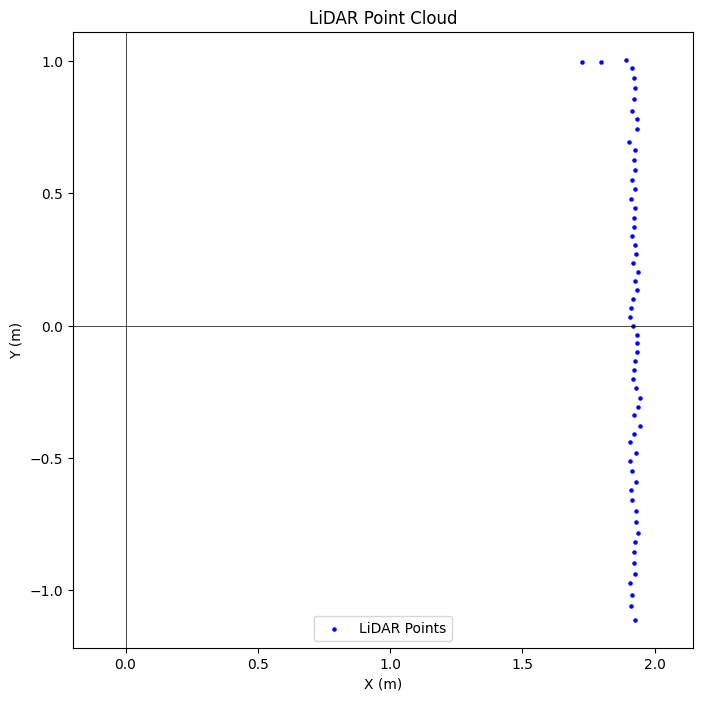

In [4]:
import matplotlib.pyplot as plt

def plot_point_cloud(point_cloud):
  # Plot the point cloud for one timestep
  x, y = point_cloud  # Choose the first timestep, for example
  plt.figure(figsize=(8, 8))
  plt.scatter(x, y, s=5, c='blue', label='LiDAR Points')
  plt.axhline(0, color='black', linewidth=0.5)
  plt.axvline(0, color='black', linewidth=0.5)
  plt.title('LiDAR Point Cloud')
  plt.xlabel('X (m)')
  plt.ylabel('Y (m)')
  plt.axis('equal')  # Equal scaling for X and Y
  plt.legend()
  plt.show()

def plot_point_cloud_with_corners(point_cloud, intersection_points):
  x, y = point_cloud
  plt.figure(figsize=(8, 8))
  plt.scatter(x, y, s=5, c='blue', label='LiDAR Points')
  for corner in intersection_points:
    plt.scatter(corner[0], corner[1], color='red', label='Intersection Point', s=100)
  plt.axhline(0, color='black', linewidth=0.5)
  plt.axvline(0, color='black', linewidth=0.5)
  plt.title('LiDAR Point Cloud')
  plt.xlabel('X (m)')
  plt.ylabel('Y (m)')
  plt.axis('equal')  # Equal scaling for X and Y
  plt.legend()
  plt.show()

plot_point_cloud(point_clouds[0])

In [5]:
from skimage.measure import LineModelND, ransac

debug = True

min_samples = 2

def extract_first_ransac_line(data_points, max_distance:int):
    inliers = []
    model_robust, inliers = ransac(data_points, LineModelND, min_samples=min_samples,
                                   residual_threshold=max_distance, max_trials=1000)
    results_inliers=[]
    results_inliers_removed=[]
    if(inliers is not None):
      for i in range(0,len(data_points)):
          if (inliers[i] == False):
              #Not an inlier
              results_inliers_removed.append(data_points[i])
              continue
          x=data_points[i][0]
          y=data_points[i][1]
          results_inliers.append((x,y))

    return np.array(results_inliers), np.array(results_inliers_removed), model_robust

max_distance = 0.03
iterations = 15

gap_threshold = 1.5
min_length = 0.4

def extract_lines_from_point_cloud(point_cloud):
    models = []
    models_points_start = []
    models_points_end = []
    for index in range(0,iterations):
            if (len(point_cloud) < min_samples):
                break
            inlier_points, inliers_removed_from_starting, model = extract_first_ransac_line(point_cloud, max_distance=max_distance)
            point_cloud=inliers_removed_from_starting
            if (len(inlier_points) < min_samples):
                break
            p0, direction = model.params
            projections = np.dot(inlier_points - p0, direction)
            projections_sorted = np.sort(projections)
            max_gap = np.max(np.diff(projections_sorted))
            min_proj = np.min(projections)
            max_proj = np.max(projections)
            start_point = p0 + min_proj * direction
            end_point = p0 + max_proj * direction
            length = np.linalg.norm(end_point - start_point)
            if debug:
              print("TESTING LINE")
              if length > min_length:
                if max_gap < gap_threshold:
                  models_points_start.append(start_point)
                  models_points_end.append(end_point)
                  models.append(model)
                elif debug:
                  print("GAP TOO BIG: ")
                  print(max_gap)
              elif debug:
                print("NOT LONG ENOUGH: ")
                print(length)
    return models, models_points_start, models_points_end

endpoint_threshold = 1.1
def is_point_close_to_endpoints(point, start, end):
    px, py = point
    x1, y1 = start
    x2, y2 = end

    distance_to_start = np.linalg.norm(np.array([px - x1, py - y1]))
    distance_to_end = np.linalg.norm(np.array([px - x2, py - y2]))

    return distance_to_start <= endpoint_threshold or distance_to_end <= endpoint_threshold

''' margin = 0.6
def is_point_within_segment(point, start, end):
    px, py = point
    x1, y1 = start
    x2, y2 = end
    return (min(x1, x2) - margin <= px <= max(x1, x2) + margin) and (min(y1, y2) - margin  <= py <= max(y1, y2) + margin) '''


def find_intersection(models, models_points_start, models_points_end):
  intersection_points = []
  for i in range(len(models)):
      for j in range(i, len(models)):
          if (i == j):
              continue
          line1 = (models[i].params[0], models[i].params[1])
          line2 = (models[j].params[0], models[j].params[1])
          p1, d1 = line1
          p2, d2 = line2

          A = np.array([d1, -d2]).T
          b = p2 - p1
          try:
              t = np.linalg.solve(A, b)
              intersection = p1 + t[0] * d1
              if is_point_close_to_endpoints(intersection, models_points_start[i], models_points_end[i]) and is_point_close_to_endpoints(intersection, models_points_start[j], models_points_end[j]):
                  intersection_points.append(intersection)
              elif debug:
                  print("INTERSECTION TOO FAR FROM ENDPOINTS")
                  print(intersection)
                  print(models_points_start[i])
                  print(models_points_end[i])
                  print(models_points_start[j])
                  print(models_points_end[j])
          except np.linalg.LinAlgError:
              continue
  return np.array(intersection_points)

intersection_points_list = []
models_bounds_list = []
for index in range(0,len(point_clouds)):
    print(index)
    models, models_points_start, models_points_end = extract_lines_from_point_cloud(point_clouds[index].T)
    models_bounds_list.append([models_points_start, models_points_end])
    #print("Found %d models" % len(models))
    intersection_points = []
    if(len(models) > 1):
        intersection_points = find_intersection(models, models_points_start, models_points_end)
    #print("Found %d intersection points" % len(intersection_points))
    intersection_points_list.append(intersection_points)

0
TESTING LINE
TESTING LINE
NOT LONG ENOUGH: 
0.07057291538311783
1
TESTING LINE
2
TESTING LINE
3
TESTING LINE
4
TESTING LINE
5
TESTING LINE
6
TESTING LINE
TESTING LINE
NOT LONG ENOUGH: 
0.39101585774612047
7
TESTING LINE
TESTING LINE
8
TESTING LINE
TESTING LINE
9
TESTING LINE
TESTING LINE
10
TESTING LINE
11
TESTING LINE
12
TESTING LINE
13
TESTING LINE
14
TESTING LINE
GAP TOO BIG: 
1.6186536811137988
TESTING LINE
15
TESTING LINE
TESTING LINE
TESTING LINE
NOT LONG ENOUGH: 
0.3380207507858571
TESTING LINE
INTERSECTION TOO FAR FROM ENDPOINTS
[-239.70344014   36.40783267]
[ 6.47865617 -0.56708057]
[0.56336156 0.32135733]
[ 2.38543724 -0.95966867]
[ 6.34979014 -1.57158427]
16
TESTING LINE
GAP TOO BIG: 
1.6863033725535237
TESTING LINE
TESTING LINE
TESTING LINE
INTERSECTION TOO FAR FROM ENDPOINTS
[  6.3599541 102.0144064]
[ 2.23083417 -0.64479954]
[ 2.20539992 -1.27715221]
[ 6.22632735 -0.7646389 ]
[6.22760405 0.21733674]
INTERSECTION TOO FAR FROM ENDPOINTS
[ 6.22639309 -0.71406792]
[ 6.22632

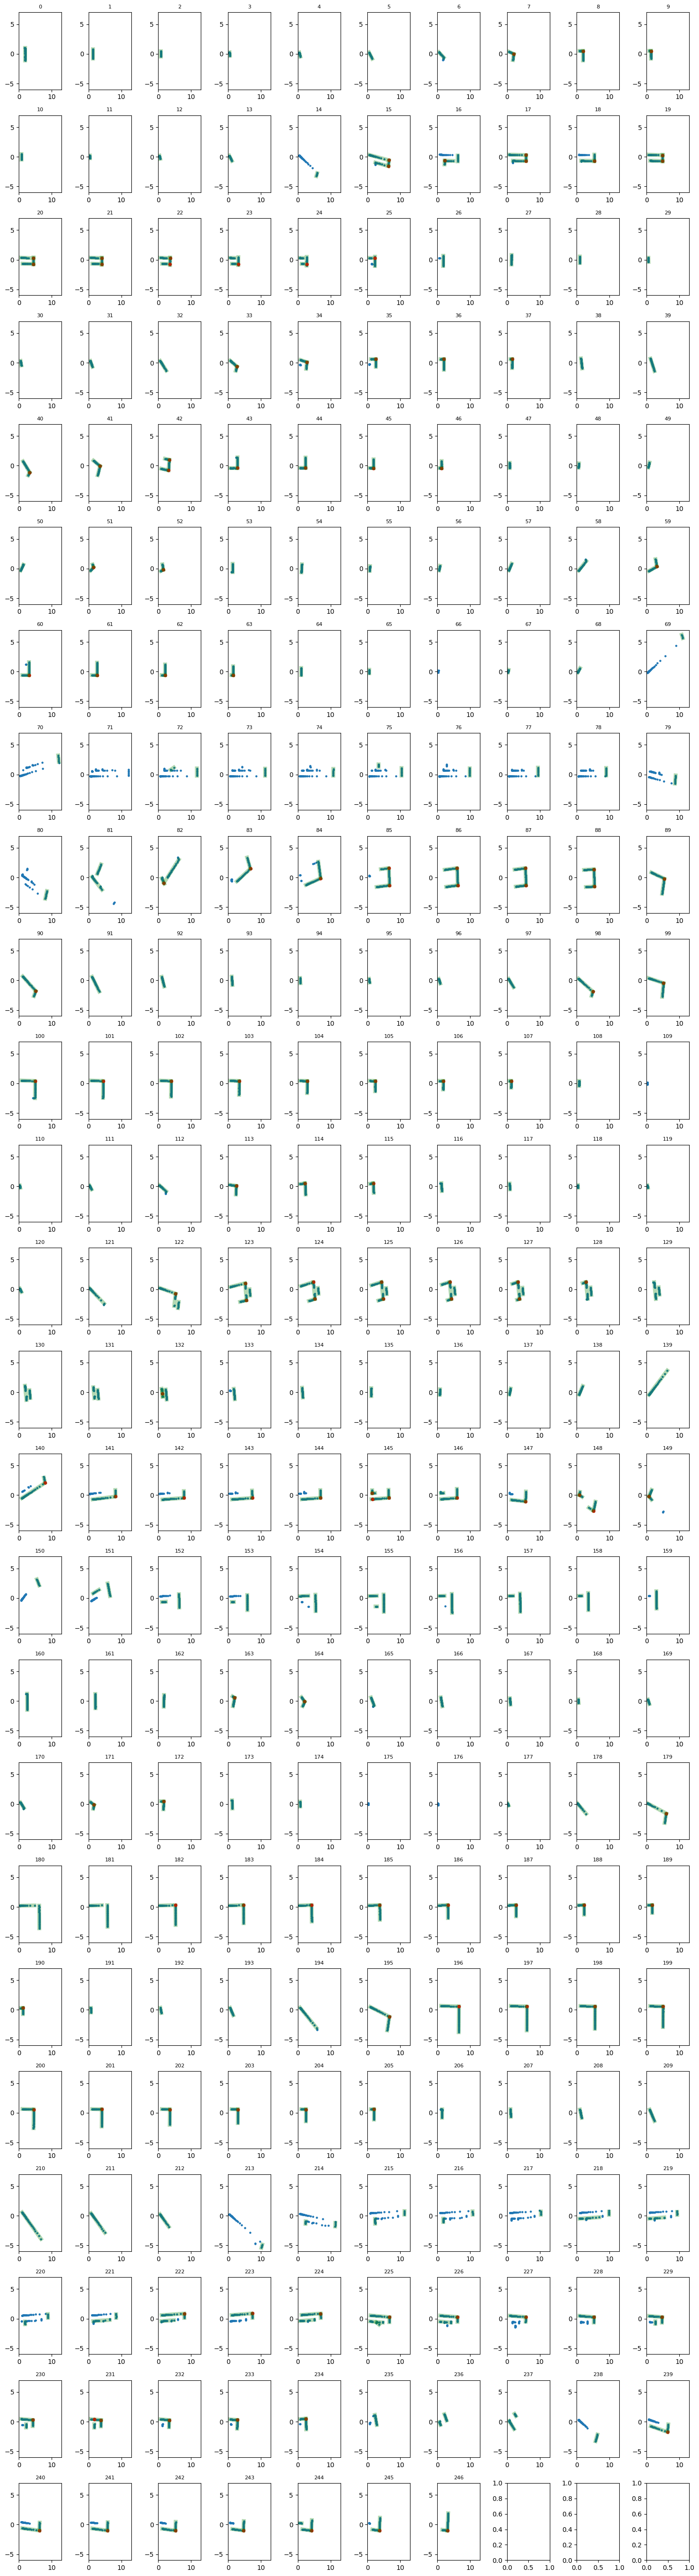

In [6]:
rows, cols = 25, 10
fig, axes = plt.subplots(rows, cols, figsize=(15, 55))
axes = axes.flatten()
for index in range(0, len(point_clouds)):
    x, y = point_clouds[index]
    axes[index].scatter(x, y, s=5)
    for index_2 in range(0, len(models_bounds_list[index][0])):
      model_bounds = models_bounds_list[index]
      start = model_bounds[0][index_2]
      end = model_bounds[1][index_2]
      axes[index].plot([start[0], end[0]], [start[1], end[1]], color='green', linewidth = 6, alpha = 0.3)
    for corner in intersection_points_list[index]:
      axes[index].scatter(corner[0], corner[1], color='red', s=20)
    axes[index].set_title(f"{index}", fontsize=8)
    axes[index].set_xlim(0, 13)
    axes[index].set_ylim(-6, 7)

plt.tight_layout()
plt.show()

### Debug

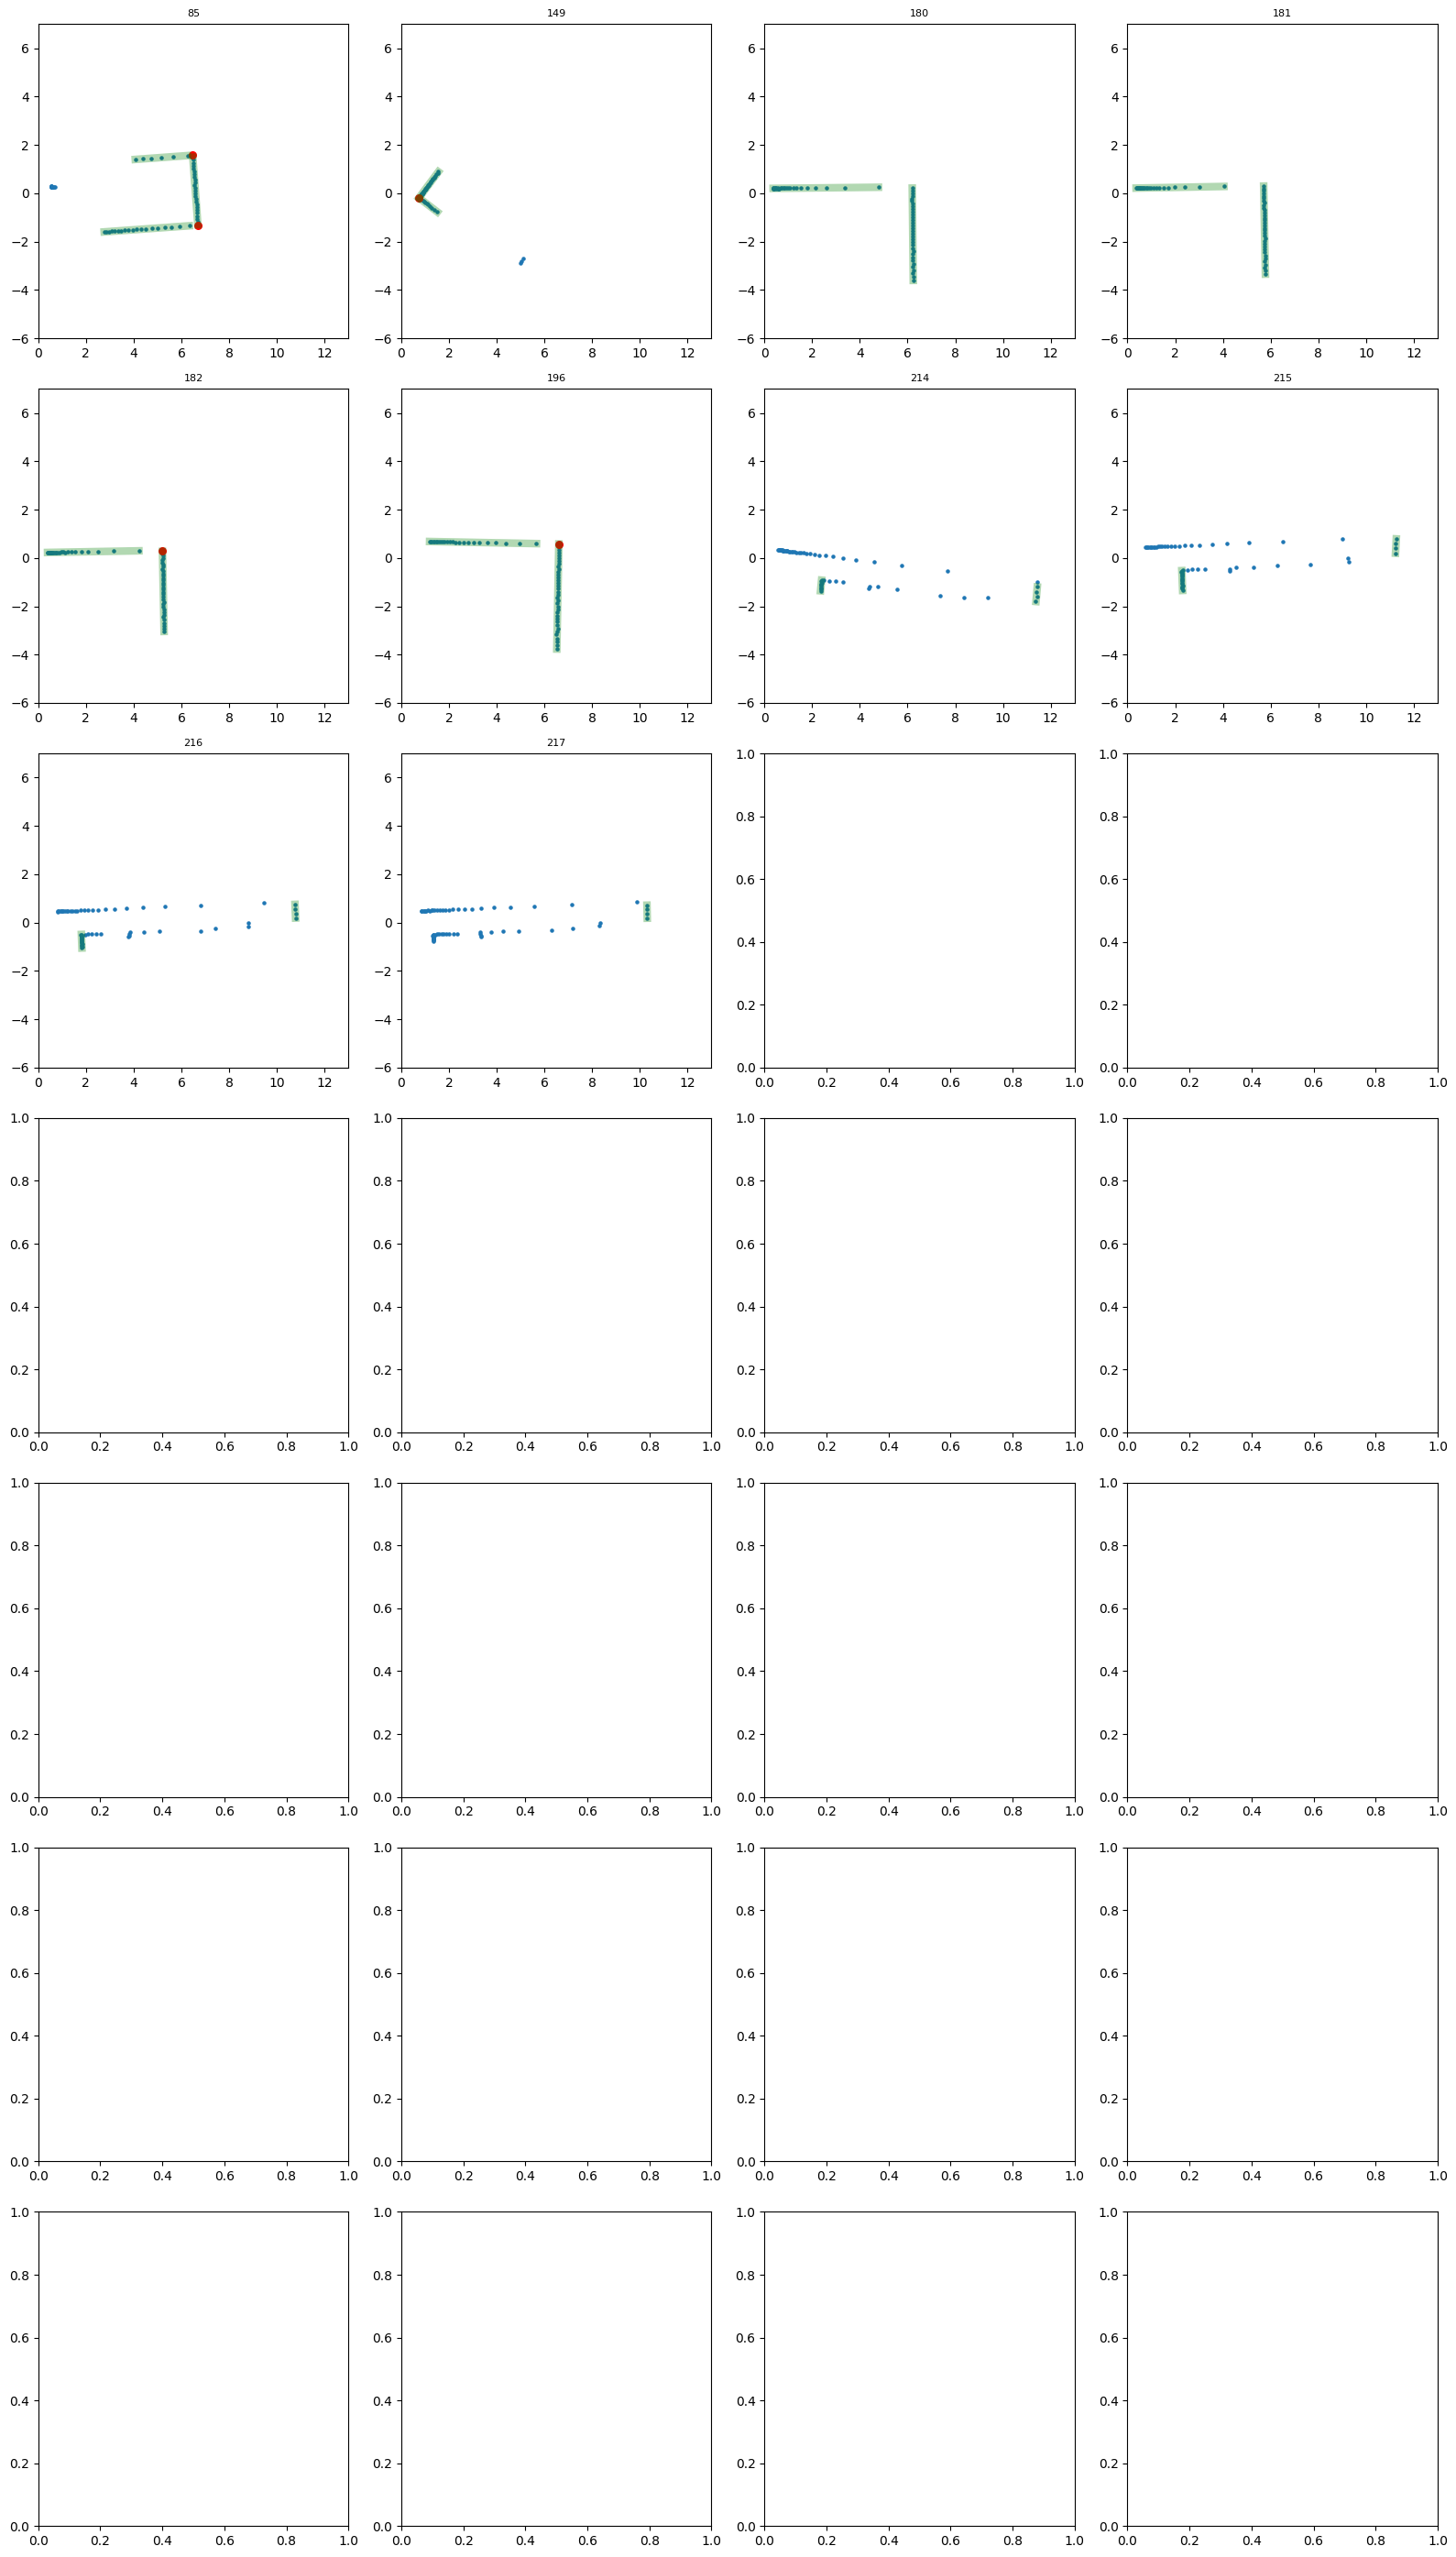

In [7]:
rows, cols = 7, 4
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()
selected_indices = [85, 149, 180, 181, 182, 196, 214, 215, 216, 217]
for i, index in enumerate(selected_indices):
    x, y = point_clouds[index]
    axes[i].scatter(x, y, s=5)
    for index_2 in range(0, len(models_bounds_list[index][0])):
      model_bounds = models_bounds_list[index]
      start = model_bounds[0][index_2]
      end = model_bounds[1][index_2]
      axes[i].plot([start[0], end[0]], [start[1], end[1]], color='green', linewidth = 6, alpha = 0.3)
    for corner in intersection_points_list[index]:
      axes[i].scatter(corner[0], corner[1], color='red', s=30)
    axes[i].set_title(f"{index}", fontsize=8)
    axes[i].set_xlim(0, 13)
    axes[i].set_ylim(-6, 7)

plt.tight_layout()
plt.show()

# Task 2
* Cada indice da intersection_points_list tem os cantos detetados para a leitura de lidar com esse mesmo inidice na point_clouds

In [ ]:
# Fazer uma montagem ao longo do tempo das leituras no referencial global estimado do robô (primeiro sem nenhuma correção, só mesmo acumulação dos deltas ao longo do tempo)
## Cada iteração soma os deltas à posição, calcula a matrix homogénea do robô em relação ao referencial global e depois multiplicar os pontos da leitura por essa matriz
## Depois mostrar as leituras numa sequência

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np

# Initial pose
x_odo = 0
y_odo = 0
th_odo = 0

# List to store trajectory points
trajectory = [(x_odo, y_odo)]

for index in range(len(pose_deltas)):
    x_odo += pose_deltas[index][0]
    y_odo += pose_deltas[index][1]
    th_odo += pose_deltas[index][2]
    trajectory.append((x_odo, y_odo))

# Convert trajectory to a NumPy array
trajectory = np.array(trajectory)

# Initialize the plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(np.min(trajectory[:, 0]) - 1, np.max(trajectory[:, 0]) + 1)
ax.set_ylim(np.min(trajectory[:, 1]) - 1, np.max(trajectory[:, 1]) + 1)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_title('Odometry Trajectory Over Time')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')

# Line and scatter elements for updating
line, = ax.plot([], [], color='blue', label='Trajectory Path')
scatter = ax.scatter([], [], color='red', s=10, label='Positions')

def update(frame):
    """Update function for animation."""
    # Update line
    line.set_data(trajectory[:frame, 0], trajectory[:frame, 1])
    # Update scatter
    scatter.set_offsets(trajectory[:frame])
    return line, scatter

# Create the animation
ani = FuncAnimation(fig, update, frames=len(trajectory), interval=100, blit=True)

# Use HTML to render the animation in the notebook
HTML(ani.to_jshtml())
